In [45]:
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torchvision import models
from torchvision import transforms

from piq import brisque, total_variation, TVLoss

In [13]:
directory_path = '/home/arazin/main/university/AMLT/IQA/dataset'
image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

image_paths, ratings = [], []

In [10]:
for image_path in image_files:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    rating = ''
    while not (rating.isdigit() and 1 <= int(rating) <= 5):
        rating = input("Enter your rating for the image (1-5): ")
    
    image_paths.append(image_path)
    ratings.append(int(rating))
    
    clear_output(wait=True)

df_images = pd.DataFrame({
    'Image': image_paths,
    'Rating': ratings
})

print("All images have been rated.")

All images have been rated.


In [18]:
df_images.sort_values(by='Rating', ascending=False, inplace=True)
df_images.reset_index(drop=True, inplace=True)
df_images

,Image,Rating
0,/home/arazin/main/university/AMLT/IQA/dataset/...,5
1,/home/arazin/main/university/AMLT/IQA/dataset/...,4
2,/home/arazin/main/university/AMLT/IQA/dataset/...,4
3,/home/arazin/main/university/AMLT/IQA/dataset/...,4
4,/home/arazin/main/university/AMLT/IQA/dataset/...,4
5,/home/arazin/main/university/AMLT/IQA/dataset/...,3
6,/home/arazin/main/university/AMLT/IQA/dataset/...,3
7,/home/arazin/main/university/AMLT/IQA/dataset/...,3
8,/home/arazin/main/university/AMLT/IQA/dataset/...,3
9,/home/arazin/main/university/AMLT/IQA/dataset/...,3


In [41]:
# Function to calculate BRISQUE score for an image
def calculate_brisque(image_path):
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1)[None, ...] / 255.  # Convert to tensor and scale

    # Move to GPU if available
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    # Calculate BRISQUE score
    score = brisque(img_tensor, data_range=1., reduction='none')
    return score.item()

# Function to calculate Total Variation score for an image
def calculate_total_variation(image_path):
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1)[None, ...] / 255.  # Convert to tensor and scale

    # Move to GPU if available
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    # Calculate Total Variation
    tv_index = total_variation(img_tensor)
    tv_loss = TVLoss(reduction='none')(img_tensor)
    
    return tv_index.item(), tv_loss.item()

# Function to calculate NIMA score for an image
def rate(img_path):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10

    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )

    # Weight Path
    weight_path = '/home/arazin/main/university/AMLT/IQA/ML-Aesthetics-NIMA/weights/dense121_all.pt'

    # Load weights
    assert os.path.exists(weight_path)
    model_ft.load_state_dict(torch.load(weight_path, map_location=torch.device('cpu')))



    img = Image.open(img_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)
    img.to('cpu')
    model_ft.to('cpu')
    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))
    
    
    # return scores.view(-1).numpy(), mean.item(), std.item()
    return mean.item()

In [ ]:
tqdm.pandas()

# Calculate BRISQUE scores and add to DataFrame
df_images['BRISQUE'] = df_images['Image'].progress_apply(calculate_brisque)

# Calculate Total Variation scores and losses, and add them to DataFrame
df_images[['TV Index', 'TV Loss']] = df_images['Image'].progress_apply(
    lambda x: pd.Series(calculate_total_variation(x))
)

# Calculate NIMA scores and add to DataFrame
df_images['NIMA Score'] = df_images['Image'].progress_apply(rate)

In [44]:
df_images

,Image,Rating,BRISQUE,TV Index,TV Loss,NIMA Score
0,/home/arazin/main/university/AMLT/IQA/dataset/...,5,13.804871,227.721313,227.721313,5.436083
1,/home/arazin/main/university/AMLT/IQA/dataset/...,4,2.818542,169.615189,169.615189,5.434833
2,/home/arazin/main/university/AMLT/IQA/dataset/...,4,48.995300,303.746124,303.746124,5.397137
3,/home/arazin/main/university/AMLT/IQA/dataset/...,4,72.924988,886.861328,886.861328,5.416006
4,/home/arazin/main/university/AMLT/IQA/dataset/...,4,28.581726,678.897827,678.897827,5.381859
5,/home/arazin/main/university/AMLT/IQA/dataset/...,3,7.510437,131.965897,131.965897,5.421684
6,/home/arazin/main/university/AMLT/IQA/dataset/...,3,37.575378,210.874329,210.874329,5.394395
7,/home/arazin/main/university/AMLT/IQA/dataset/...,3,26.015808,179.936127,179.936127,5.426827
8,/home/arazin/main/university/AMLT/IQA/dataset/...,3,37.986023,319.901947,319.901947,5.403281
9,/home/arazin/main/university/AMLT/IQA/dataset/...,3,19.486511,144.880051,144.880051,5.406047


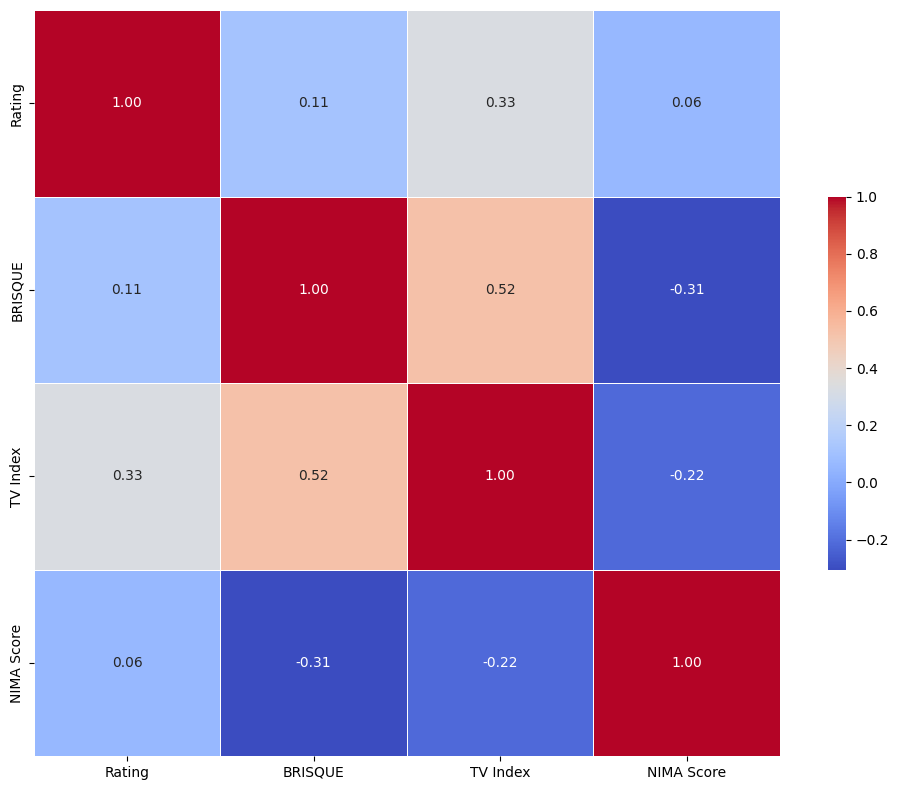

In [47]:
# Calculate the correlation matrix
corr = df_images[['Rating', 'BRISQUE', 'TV Index', 'NIMA Score']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

TV index has the best direct correlation. However, it is hard to estimate image quality on pixel level, when all images do not have too much noise.